In [21]:
import os
os.chdir('/Users/yinancheng/Documents/Project/TrustworthyAI/Advertisement/')

import pandas as pd
task_id = 18800
path = f'Data/potential_{task_id}'
label = 'label_x'

result_path = f'Result/potential_{task_id}'
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [22]:
import pandas as pd
df_train = pd.read_csv(f'{path}/df_train.csv')
df_syn_ctgan = pd.read_csv(f'{path}/df_syn_ctgan.csv')
df_syn_ctabgan = pd.read_csv(f'{path}/df_syn_ctabgan.csv')
df_syn_tvae = pd.read_csv(f'{path}/df_syn_tvae.csv')
df_syn_ds = pd.read_csv(f'{path}/df_syn_ds.csv')
#df_syn_great = pd.read_csv(f'{path}/df_syn_great.csv')
df_syn_tabula = pd.read_csv(f'{path}/df_syn_tabula.csv')
#df_syn_tabddpm = pd.read_csv(f'{path}/df_syn_tabddpm.csv')
df_holdout = pd.read_csv(f'{path}/df_holdout.csv')
df_val = pd.read_csv(f'{path}/df_val.csv')
print("data is loaded...")

data is loaded...


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from pygam import LogisticGAM
from xgboost import XGBClassifier
from nam.wrapper import NAMClassifier

# Dictionary of models
models = {
    'LR': LogisticRegression(),
    'DT': DecisionTreeClassifier(random_state=0),
    'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC(random_state=0, probability=True),
    'RF': RandomForestClassifier(random_state=0),    
    #'GAM': LogisticGAM(), # Does not converge
    'XGB': XGBClassifier()#,
    #'NAM': NAMClassifier()
}

In [25]:
# Use the following loop, we can get sets of predictors and sets of response of each synthetic dataset
# For example, X_CTGAN is the set of predictors for the df_syn_ctgan sample
X_training = df_train.drop(label, axis=1) # Predictors of training
y_training = df_train[label] # Response of training
X_holdout = df_holdout.drop(label, axis=1) # Predictors of holdout
y_holdout = df_holdout[label] # Response of holdout
X_val = df_val.drop(label, axis=1) # Predictors of valide
y_val = df_val[label] # Response of valid

synthetic = {
    'CTGAN': df_syn_ctgan,
    'CTABGAN': df_syn_ctabgan,
    'TVAE': df_syn_tvae,
    'DS': df_syn_ds,
    #'GReaT': df_syn_great,
    'Tabula': df_syn_tabula,
    #'TabDDPM': df_syn_tabddpm
}

import numpy as np
# list of all datasets used to train models
all_datasets = ['Training','Holdout']
for name, sample_data in synthetic.items():
    for r in range(5):
        ratio = r + 1
        np.random.seed(0)
        sampledata = sample_data.sample(frac = 0.1*ratio)
        globals()[f'df_syn{ratio}_{name}_train'] = mixed_train = pd.concat([df_train, sampledata])
        globals()[f'df_syn{ratio}_{name}_holdout'] = mixed_holdout = pd.concat([df_holdout, sampledata])
        
        globals()[f'X_training_{name}_{ratio}'] = mixed_train.drop(label, axis=1) # Predictors
        globals()[f'y_training_{name}_{ratio}'] = mixed_train[label] # Response
        
        globals()[f'X_holdout_{name}_{ratio}'] = mixed_holdout.drop(label, axis=1) # Predictors
        globals()[f'y_holdout_{name}_{ratio}'] = mixed_holdout[label] # Response
        all_datasets.append(f'training_{name}_{ratio}')
        all_datasets.append(f'holdout_{name}_{ratio}')

In [26]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import f1_score,recall_score, precision_score

# Create a dataframe to save the result
sample_model = []
for sample_data in all_datasets:
    for model in models.keys():
        sample_model.append(f'{sample_data}_{model}')        
columns=['Accuracy', 'AUC', 'F1', 'Recall','Precision', 'AP','TPR', 'FPR', 'TNR', 'FNR']
result_mixed = pd.DataFrame(index = sample_model, columns=columns)

def model_evaluation(name, model, sample, X_train, y_train, X_val, y_val):
    # Standardize training set and valid set 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # Predict probabilities
    if ind == 1:
        y_proba = model.predict_proba(X_val) # When the model is GAM or NAM
    else:
        y_proba = model.predict_proba(X_val)[:,1] # Otherwise
    
    # Metric 1: accuracy
    accuracy = accuracy_score(y_val, y_pred)
    # Metric 2: ROC AUC
    auroc = roc_auc_score(y_val, y_proba)
    # Metric 3: F1 score
    f1 = f1_score(y_val, y_pred)
    # Metric 4: recall score
    recall = recall_score(y_val, y_pred) 
    # Metric 5: precision score
    precision = precision_score(y_val, y_pred)  
    # Metric 6: average_precision    
    ap = average_precision_score(y_val, y_proba)
    # Metric 7: confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    tpr = tp / (tp + fn)  
    fpr = fp / (fp + tn)  
    tnr = tn / (tn + fp)  
    fnr = fn / (tp + fn)
    
    result_mixed.loc[f'{sample}_{name}'] = [
        round(accuracy, 3), round(auroc, 3), round(f1, 3), round(recall, 3), round(precision, 3), round(ap, 3),
        round(tpr, 3), round(fpr, 3), round(tnr, 3), round(fnr, 3)
    ]
    
    # For figures
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    globals()[f'{sample}_{name}_fpr'] = fpr
    globals()[f'{sample}_{name}_tpr'] = tpr
    globals()[f'{sample}_{name}_auc'] = roc_auc
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    ap = average_precision_score(y_val, y_proba)
    globals()[f'{sample}_{name}_precision'] = precision
    globals()[f'{sample}_{name}_recall'] = recall
    globals()[f'{sample}_{name}_ap'] = ap
    
    #print(sample + " "+ name +" done")

In [27]:
for name, model in models.items():
    if name == "GAM" or name == "NAM":
        ind = 1
    else:
        ind = 0
    model_evaluation(name, model, "Training", X_training, y_training, X_val, y_val)
    model_evaluation(name, model, "Holdout", X_holdout, y_holdout, X_val, y_val)
        

for sample_data in all_datasets[2:]:
    mixed_name = f'{sample_data}'
    X_train = globals()[f'X_{mixed_name}']
    y_train = globals()[f'y_{mixed_name}']
    for name, model in models.items():
        if name == "GAM" or name == "NAM":
            ind = 1
        else:
            ind = 0
        model_evaluation(name, model, mixed_name, X_train, y_train, X_val, y_val)

result_mixed.to_csv(f"{path}/result_mixed.csv", index = True)
result_mixed.to_csv(f"{result_path}/result_mixed.csv", index = True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

***CTGAN_2 means traning data + 20% CTGAN synthetic data***

In [15]:
result_mixed.to_csv(f"{path}/result_mixed.csv", index = True)
result_mixed.to_csv(f"{result_path}/result_mixed.csv", index = True)

In [28]:
result_mixed = pd.read_csv(f'{path}/result_mixed.csv', index_col = 'Unnamed: 0')

In [29]:
result_mixed

Accuracy    AUC     F1  Recall  Precision     AP    TPR  \
Training_LR              0.974  0.658  0.000   0.000      0.000  0.062  0.000   
Training_DT              0.953  0.546  0.080   0.078      0.082  0.033  0.078   
Training_KNN             0.973  0.578  0.000   0.000      0.000  0.040  0.000   
Training_NB              0.071  0.671  0.051   0.969      0.026  0.050  0.969   
Training_SVM             0.974  0.627  0.000   0.000      0.000  0.069  0.000   
...                        ...    ...    ...     ...        ...    ...    ...   
holdout_Tabula_5_KNN     0.973  0.603  0.000   0.000      0.000  0.053  0.000   
holdout_Tabula_5_NB      0.897  0.646  0.073   0.156      0.048  0.046  0.156   
holdout_Tabula_5_SVM     0.974  0.634  0.000   0.000      0.000  0.090  0.000   
holdout_Tabula_5_RF      0.972  0.694  0.167   0.109      0.350  0.132  0.109   
holdout_Tabula_5_XGB     0.972  0.672  0.169   0.109      0.368  0.164  0.109   

                        FPR    TNR    FNR  
Training_LR           0.000  1.000  1.000  
Training_DT           0.023  0.977  0.922  
Training_KNN          0.001  0.999  1.000  
Training_NB           0.953  0.047  0.031  
Training_SVM          0.000  1.000  1.000  
...                     ...    ...    ...  
holdout_Tabula_5_KNN  0.001  0.999  1.000  
holdout_Tabula_5_NB   0.083  0.917  0.844  
holdout_Tabula_5_SVM  0.000  1.000  1.000  
holdout_Tabula_5_RF   0.005  0.995  0.891  
holdout_Tabula_5_XGB  0.005  0.995  0.891  

[364 rows x 10 columns]

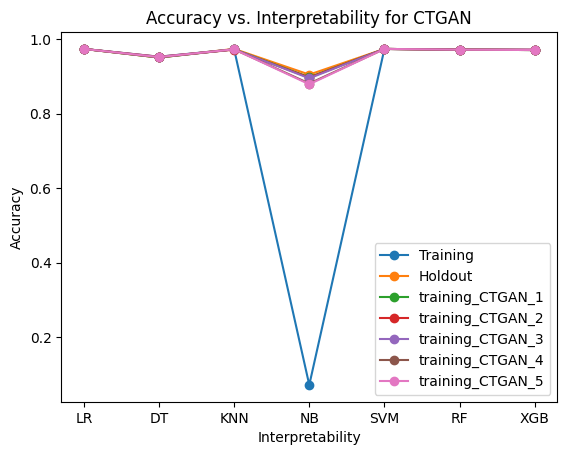

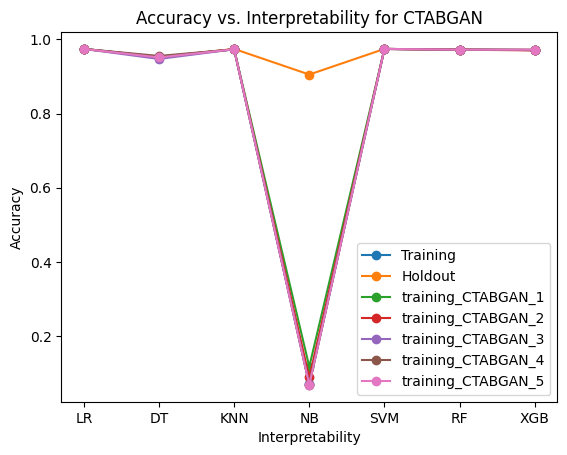

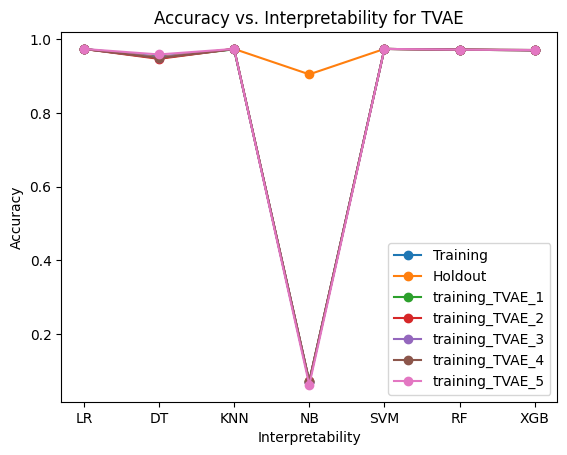

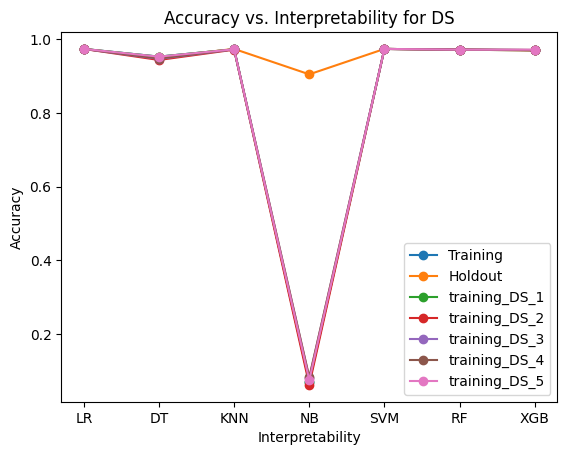

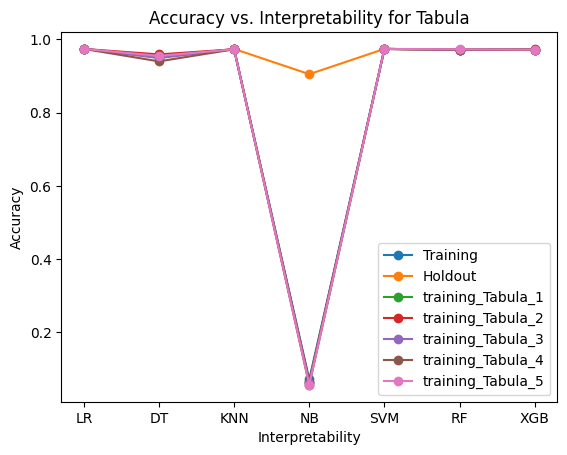

In [30]:
import matplotlib.pyplot as plt

# Plot of Accuracy
for syn in synthetic.keys():
    for r in range(7):
        accuracy = []
        ratio = r - 1
        for model in models.keys():
            if ratio == -1:
                index_name = 'Training'
            elif ratio == 0:
                index_name = 'Holdout'
            else:
                index_name = f'training_{syn}_{ratio}'
            accuracy.append(result_mixed.loc[f'{index_name}_{model}']["Accuracy"])
        plt.plot(models.keys(), accuracy , 'o-', label=f'{index_name}')
    plt.title(f'Accuracy vs. Interpretability for {syn}')
    plt.xlabel('Interpretability')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")
    plt.show()

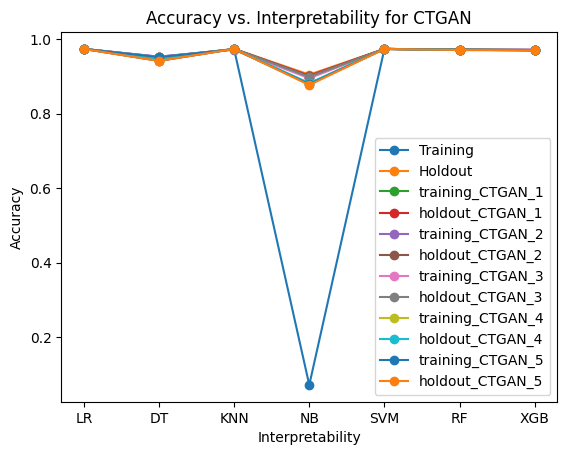

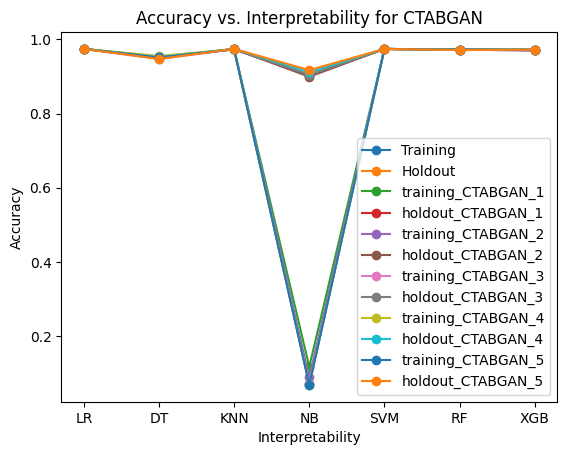

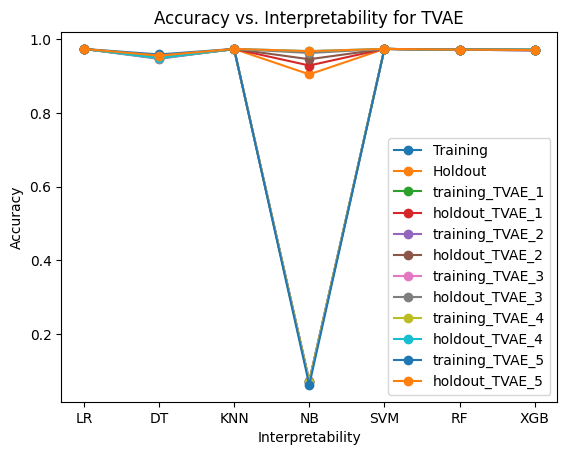

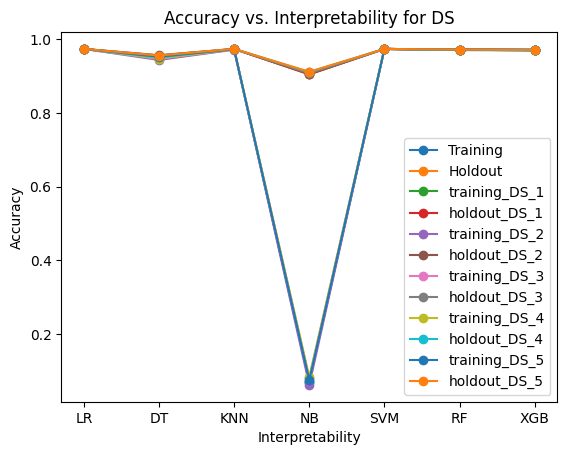

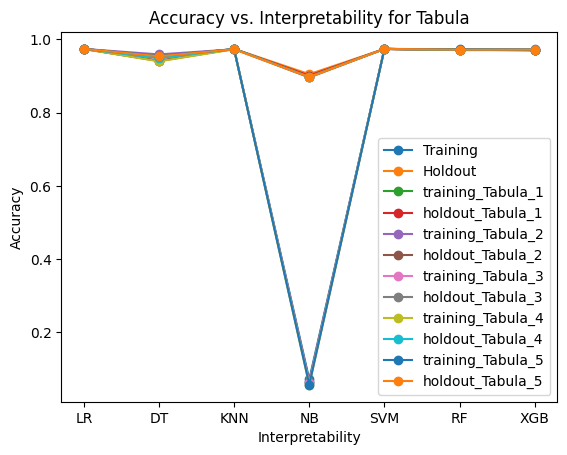

In [31]:
import matplotlib.pyplot as plt

# Plot of Accuracy
for syn in synthetic.keys():
    for r in range(7):
        accuracy = []
        ratio = r - 1
        for model in models.keys():
            if ratio == -1:
                index_name = 'Training'
            elif ratio == 0:
                index_name = 'Holdout'
            else:
                index_name = f'training_{syn}_{ratio}'
            accuracy.append(result_mixed.loc[f'{index_name}_{model}']["Accuracy"])
        plt.plot(models.keys(), accuracy , 'o-', label=f'{index_name}')
        
        accuracy1 = []
        if ratio > 0:
            for model in models.keys():            
                index_name = f'holdout_{syn}_{ratio}'
                accuracy1.append(result_mixed.loc[f'{index_name}_{model}']["Accuracy"])
            plt.plot(models.keys(), accuracy1 , 'o-', label=f'{index_name}')
        
        
    plt.title(f'Accuracy vs. Interpretability for {syn}')
    plt.xlabel('Interpretability')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")
    plt.show()

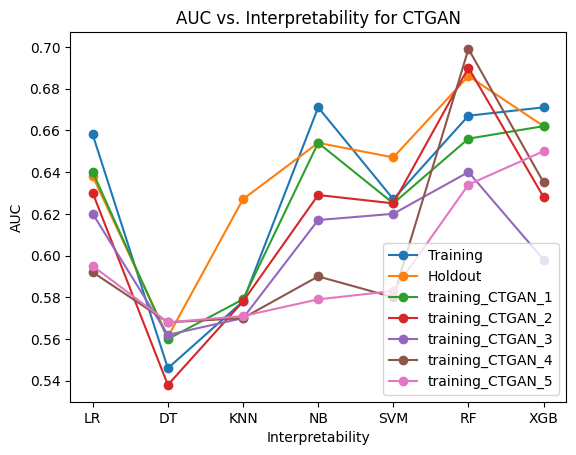

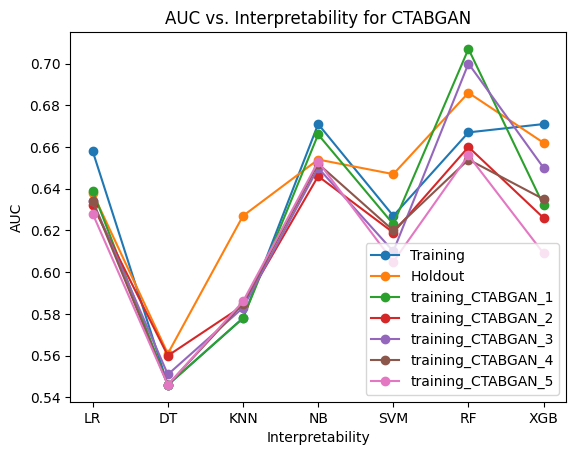

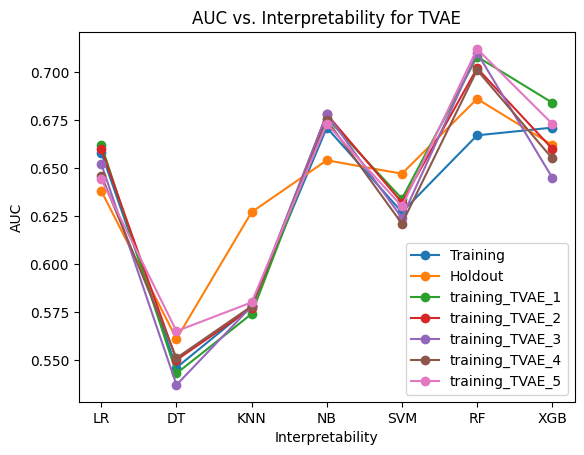

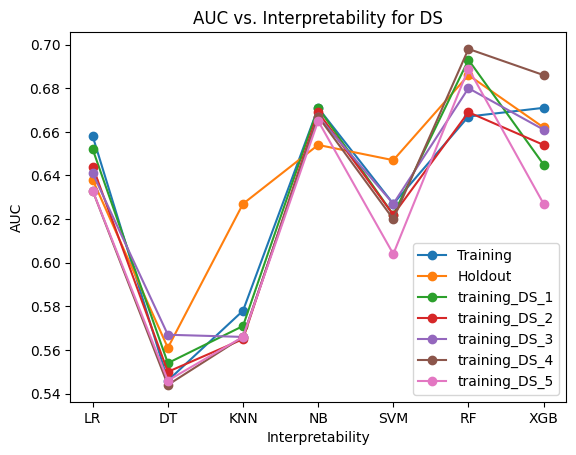

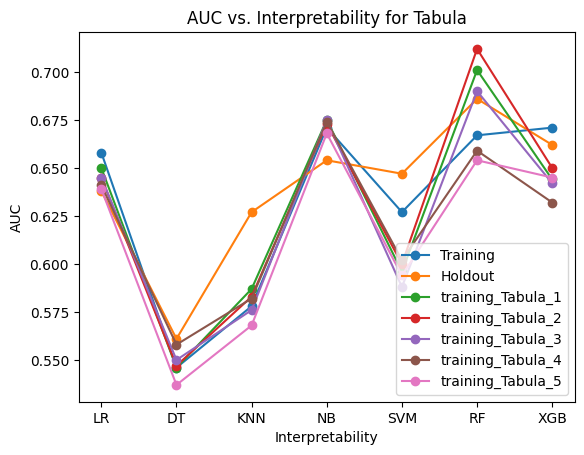

In [32]:
# Plot of AUC
for syn in synthetic.keys():
    for r in range(7):
        auc = []
        ratio = r -1
        for model in models.keys():
            if ratio == -1:
                index_name = 'Training'
            elif ratio == 0:
                index_name = 'Holdout'
            else:
                index_name = f'training_{syn}_{ratio}'
            auc.append(result_mixed.loc[f'{index_name}_{model}']["AUC"])
        plt.plot(models.keys(), auc , 'o-', label=f'{index_name}')
    plt.title(f'AUC vs. Interpretability for {syn}')
    plt.xlabel('Interpretability')
    plt.ylabel('AUC')
    plt.legend(loc="lower right")
    plt.show()

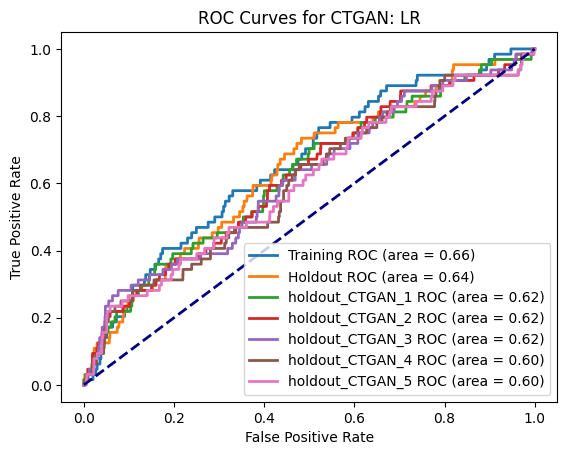

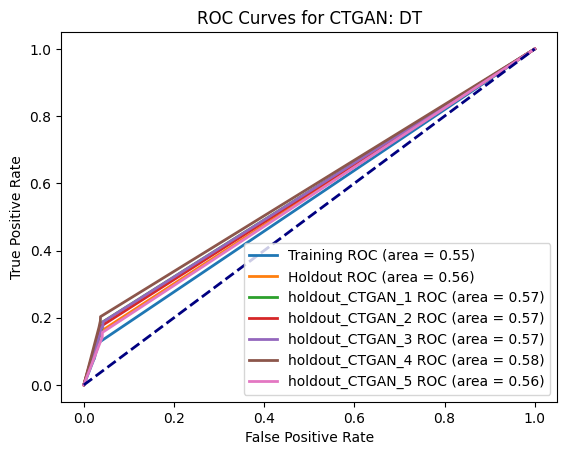

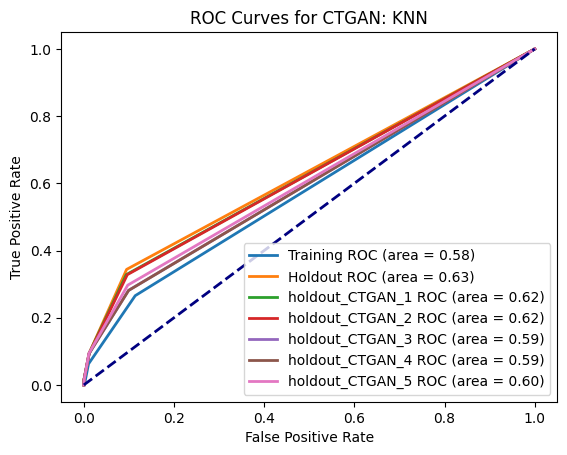

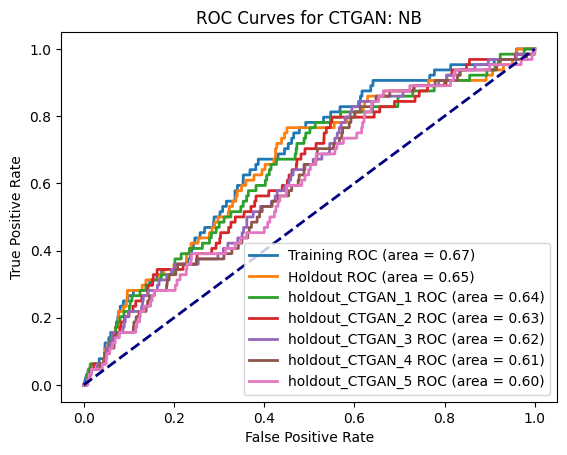

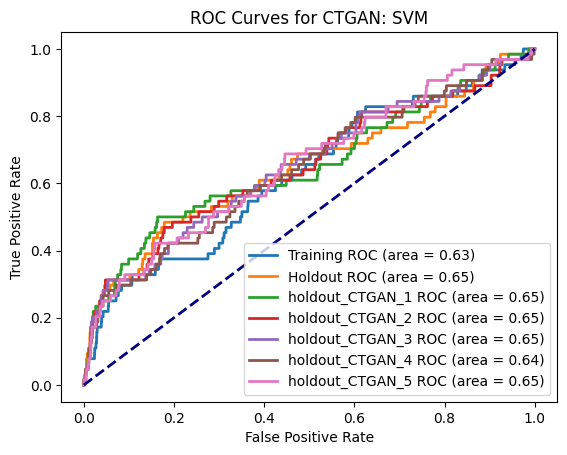

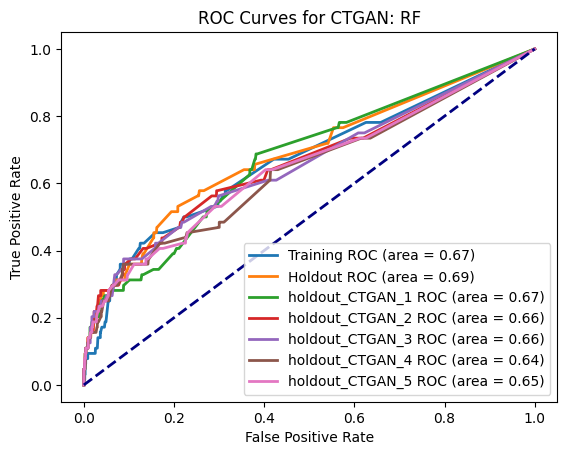

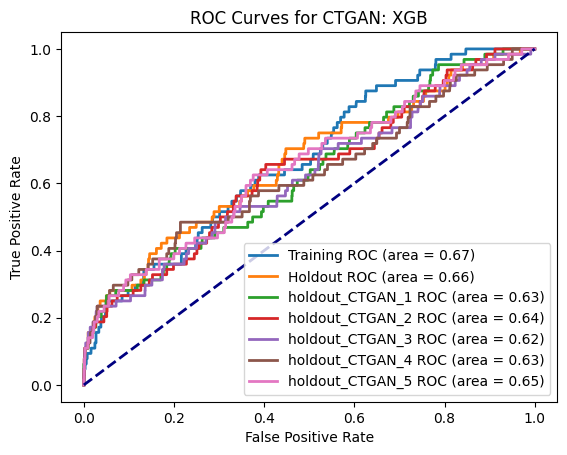

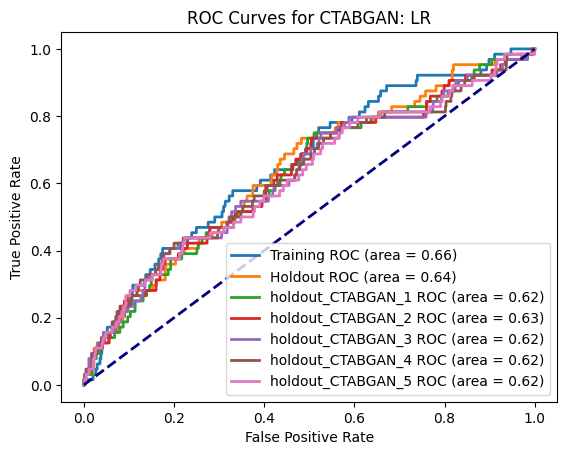

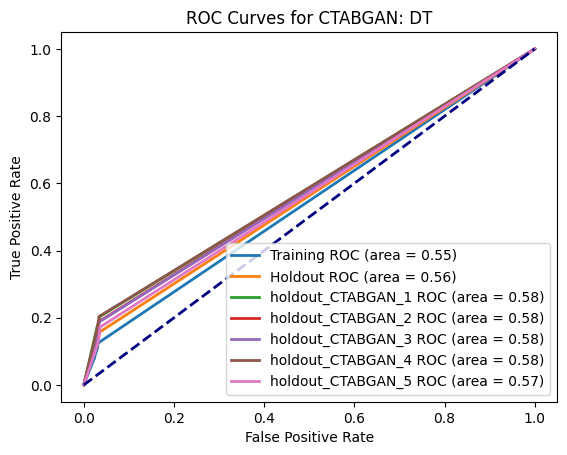

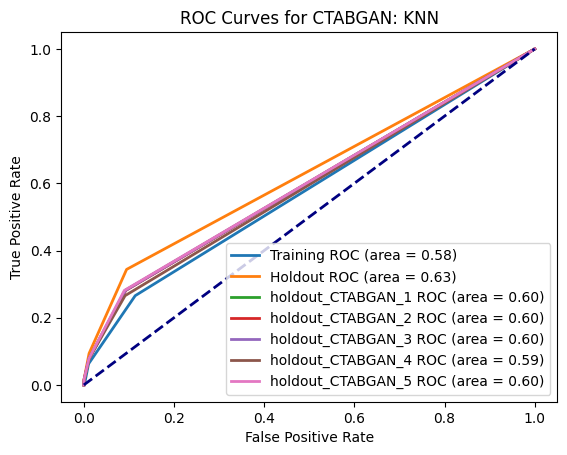

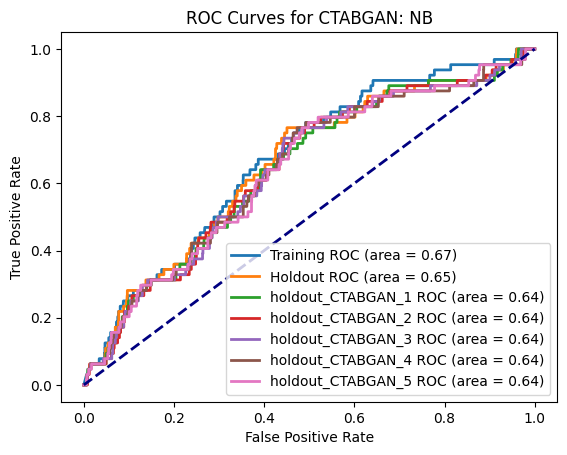

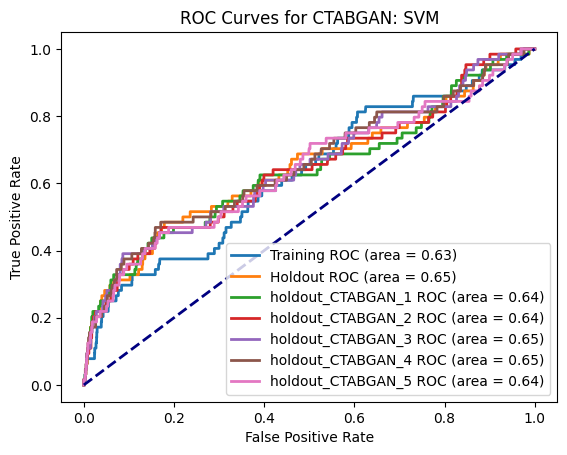

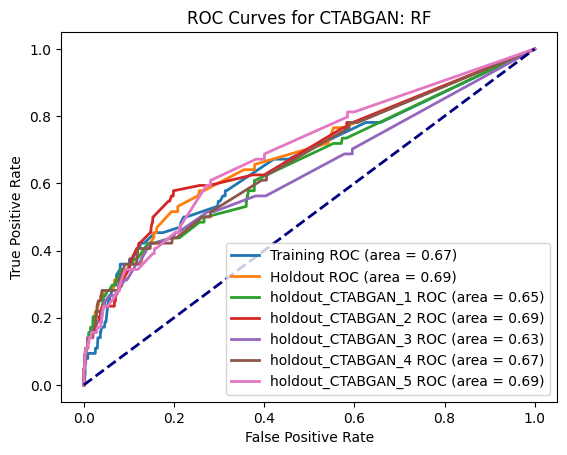

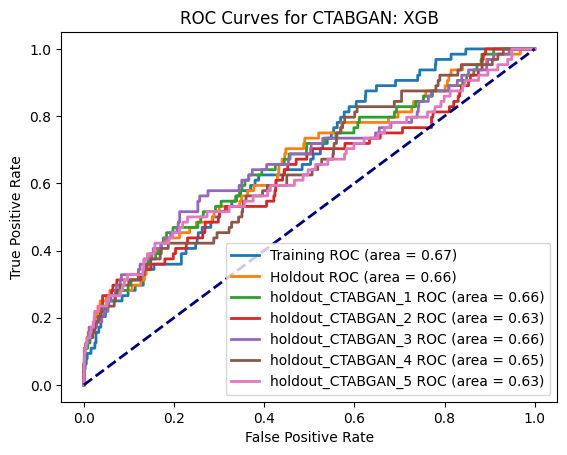

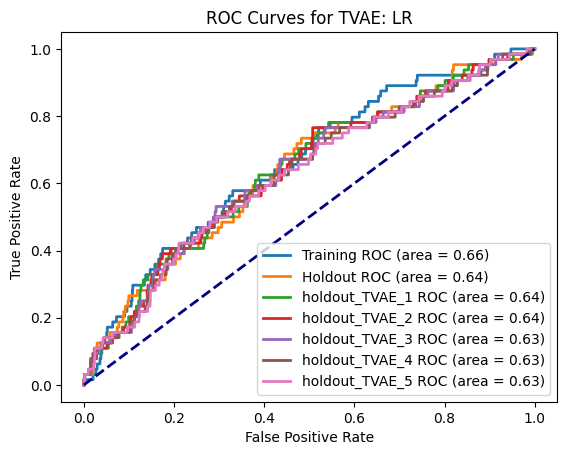

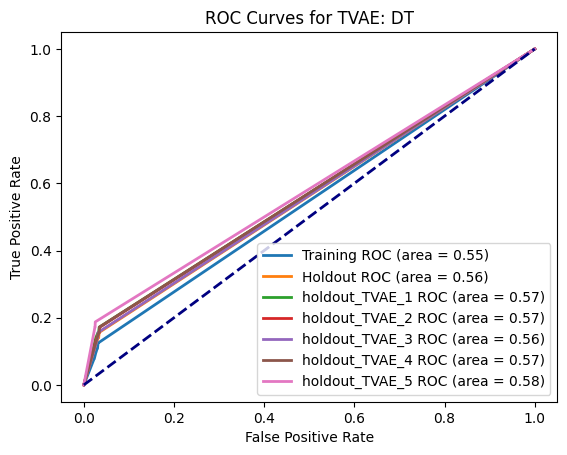

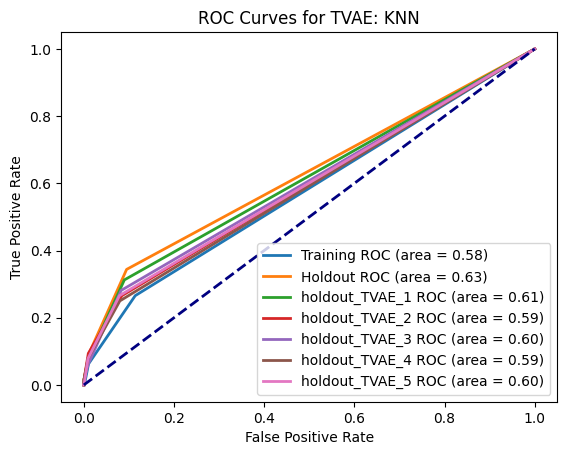

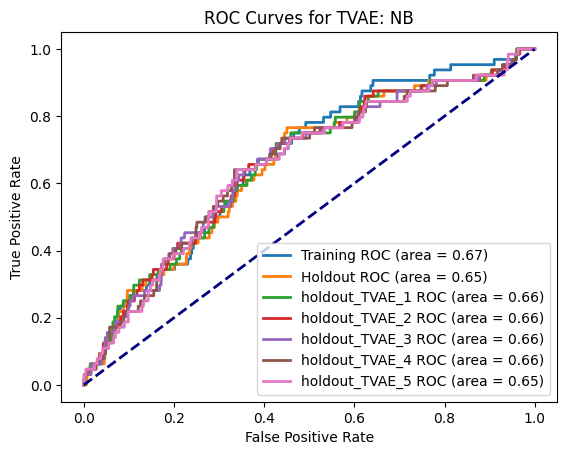

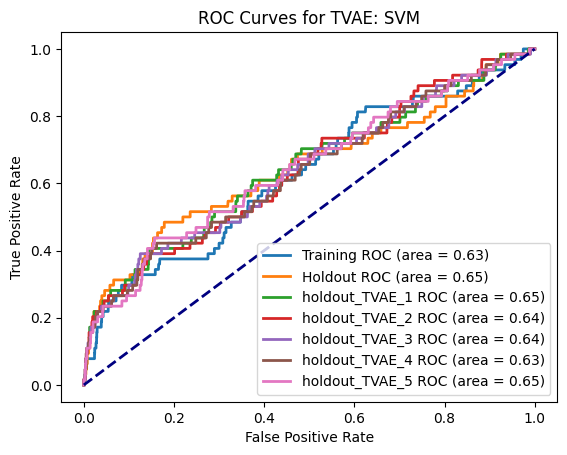

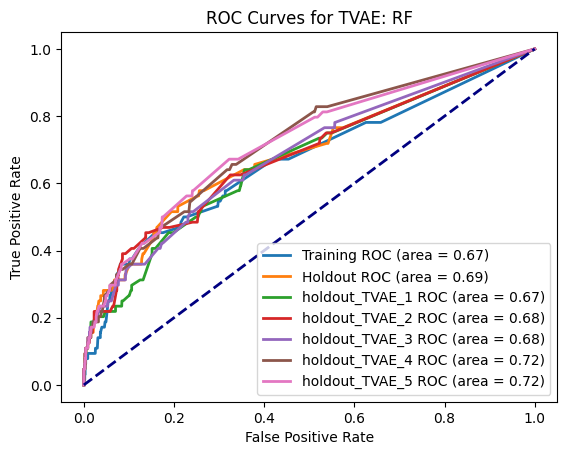

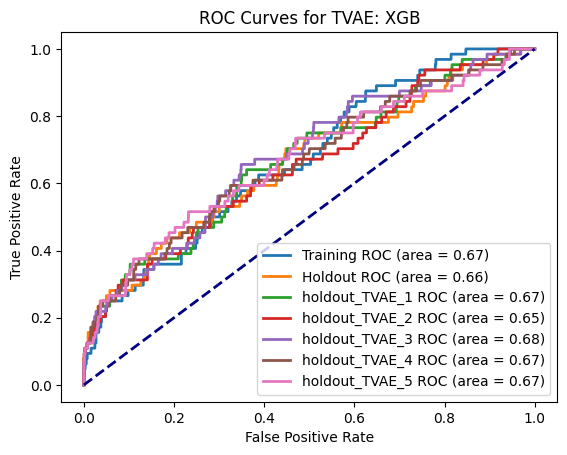

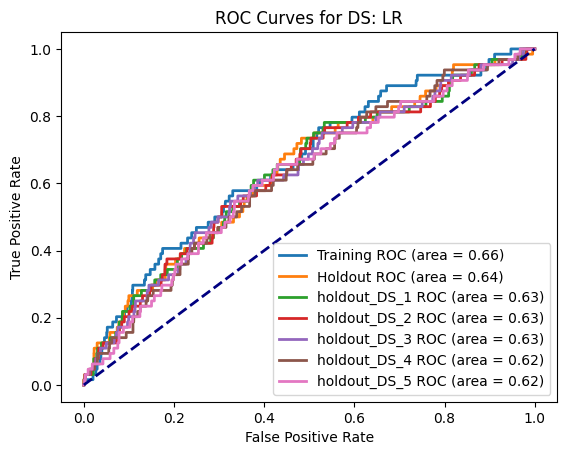

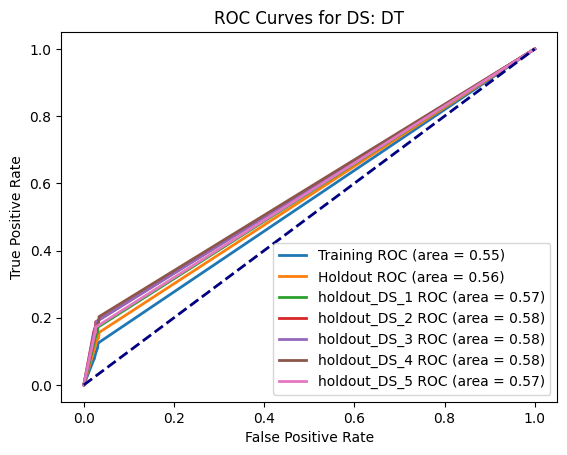

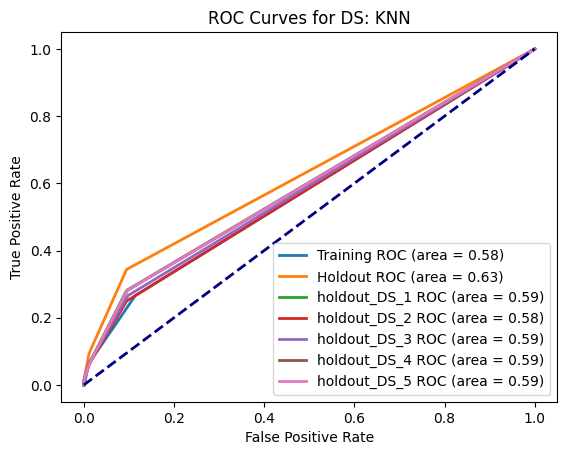

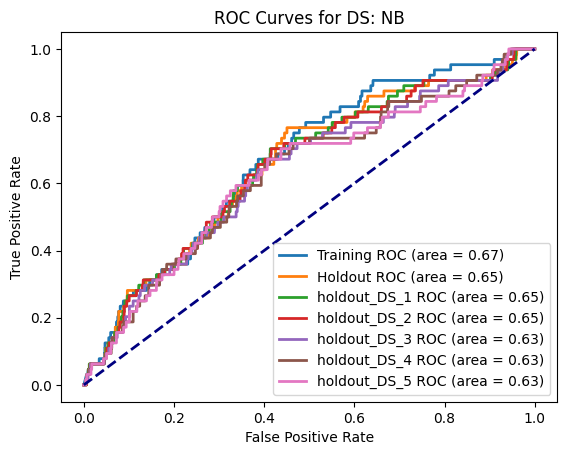

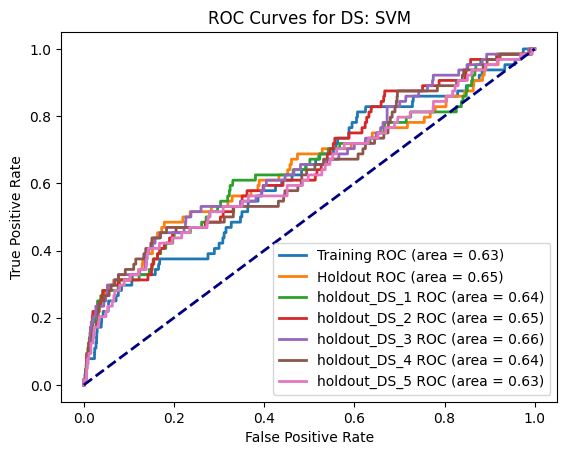

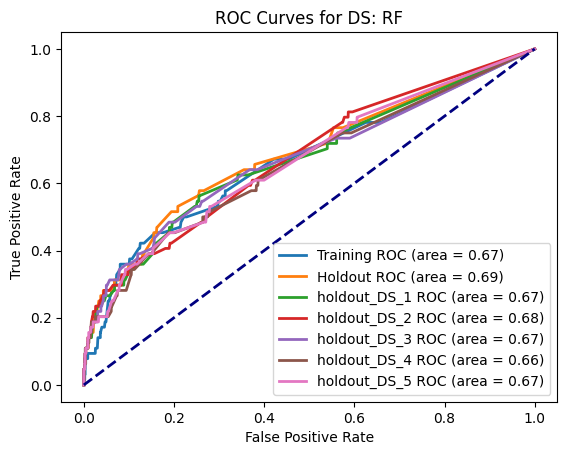

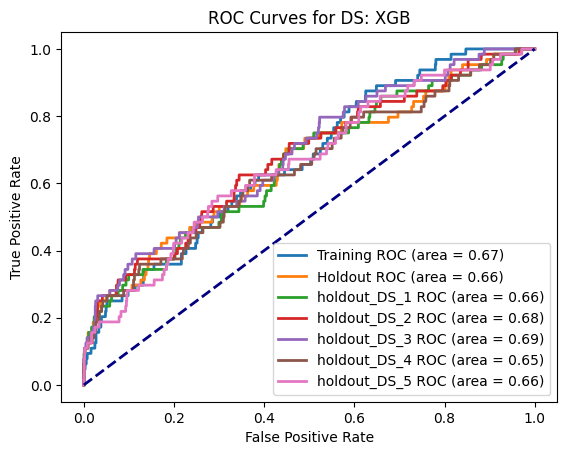

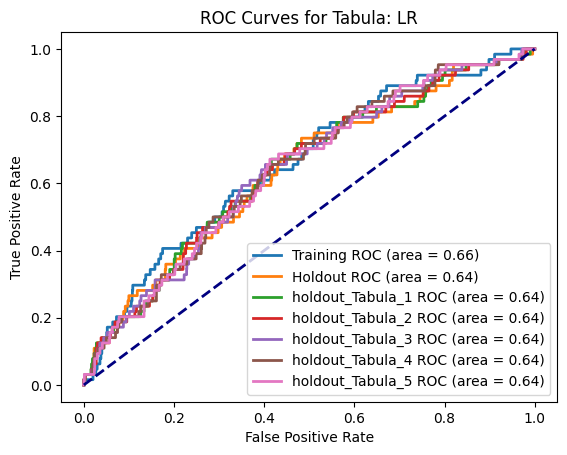

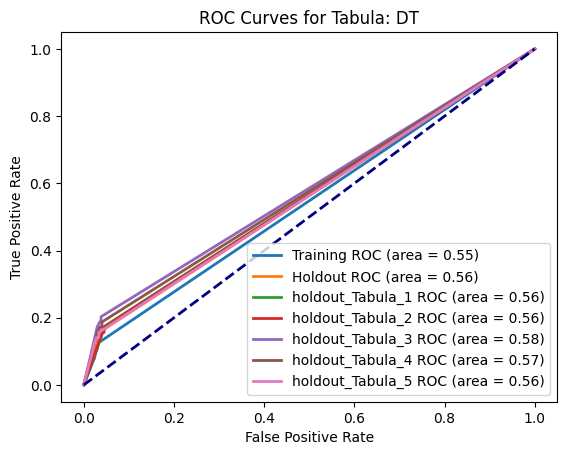

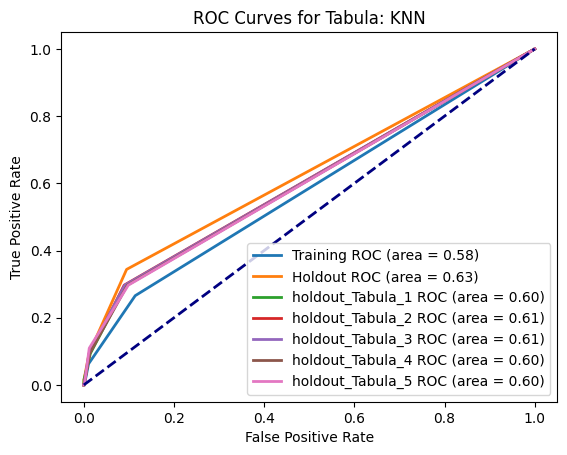

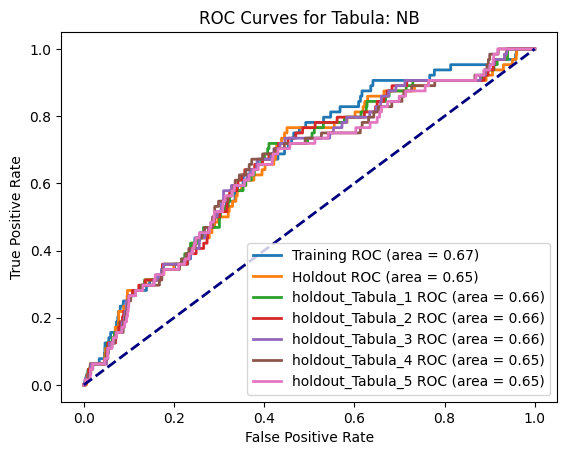

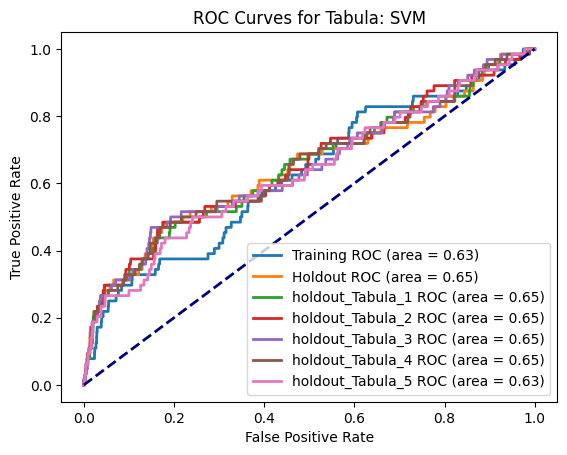

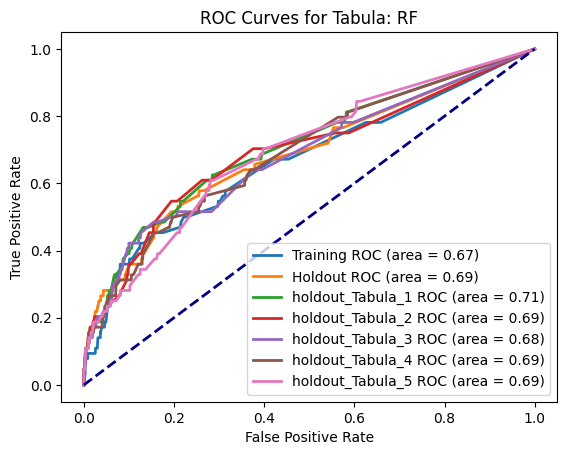

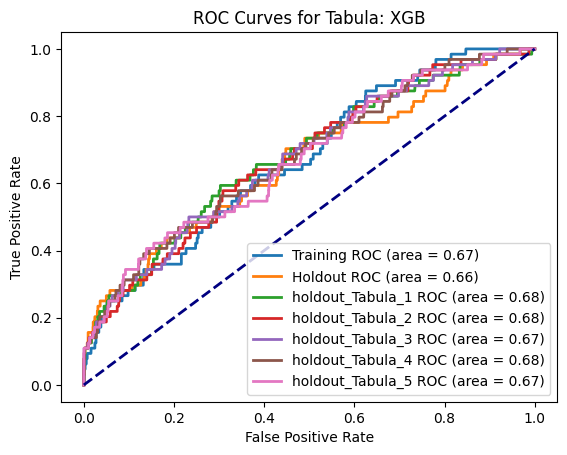

In [33]:
# Plot of ROC Curves
for syn in synthetic.keys():
    for model in models.keys():        
        for r in range(7):
            ratio = r -1
            if ratio == -1:
                index_name = 'Training'
            elif ratio == 0:
                index_name = 'Holdout'
            else:
                index_name = f'holdout_{syn}_{ratio}'
            roc_auc = globals()[f'{index_name}_{model}_auc']
            plt.plot(globals()[f'{index_name}_{model}_fpr'], globals()[f'{index_name}_{model}_tpr'], lw=2, label=f'{index_name} ROC (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves for {syn}: {model}')
        plt.legend(loc="lower right")
        plt.show()

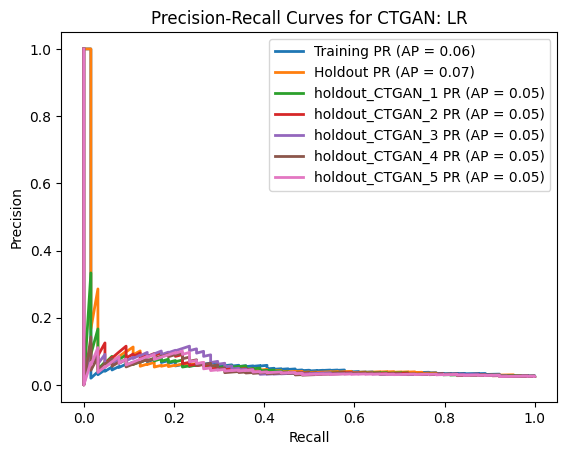

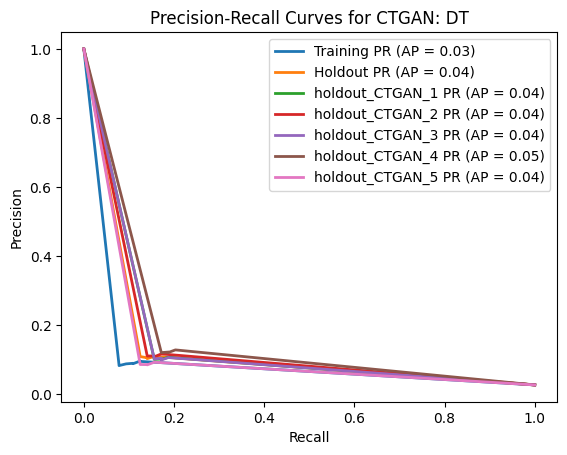

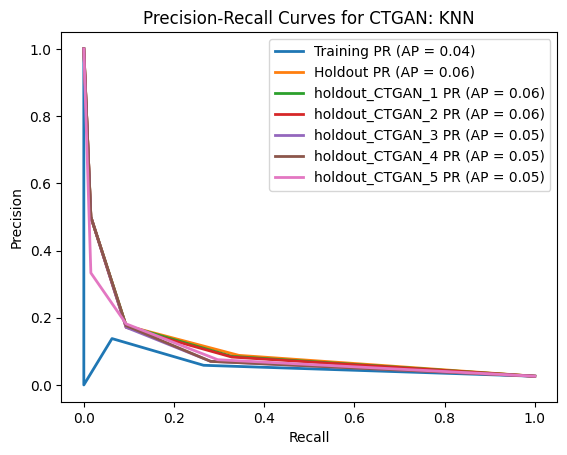

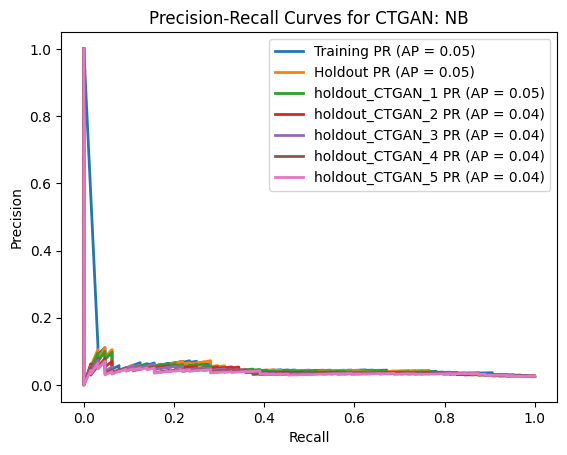

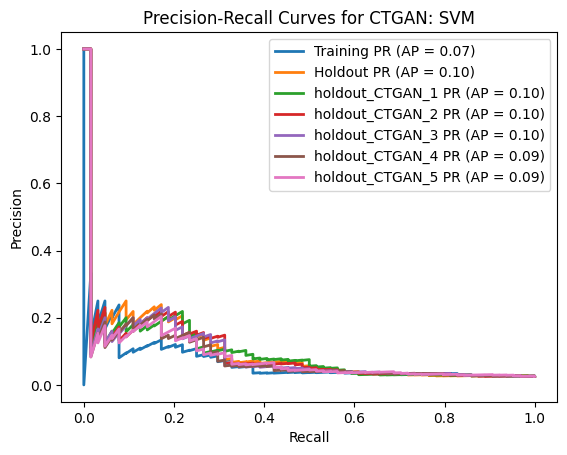

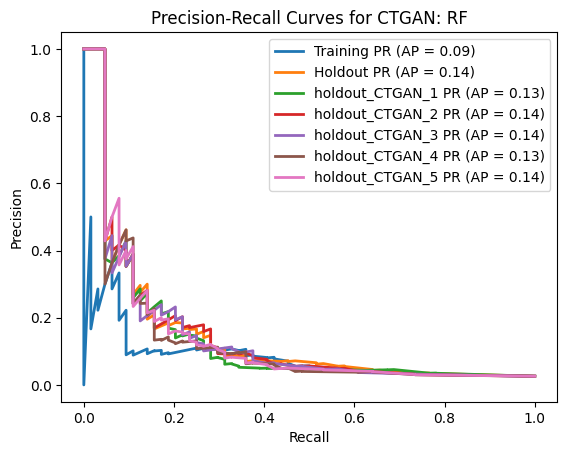

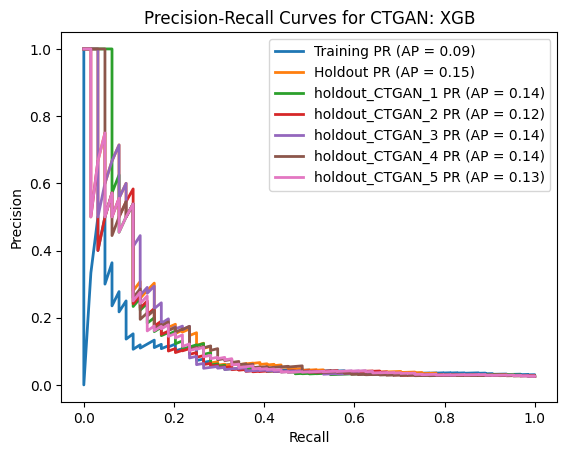

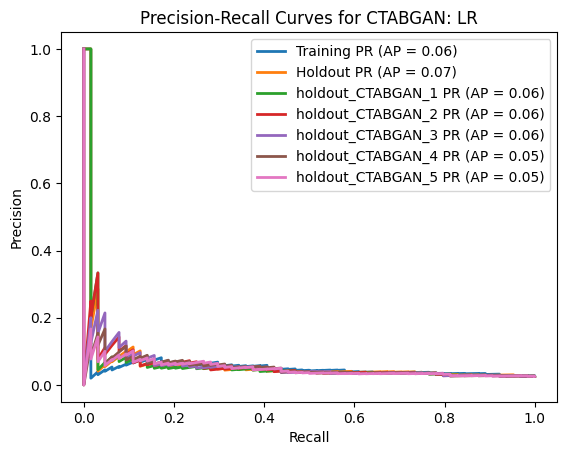

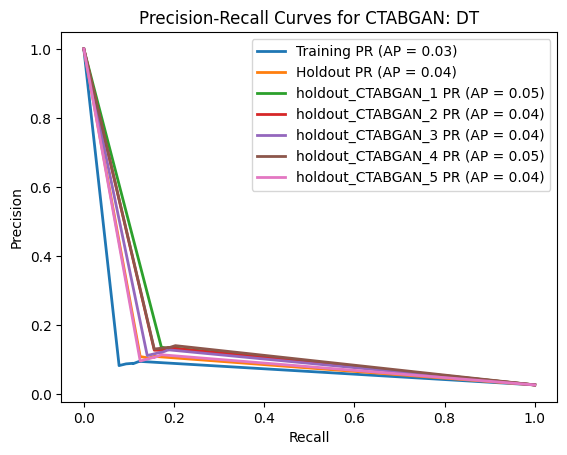

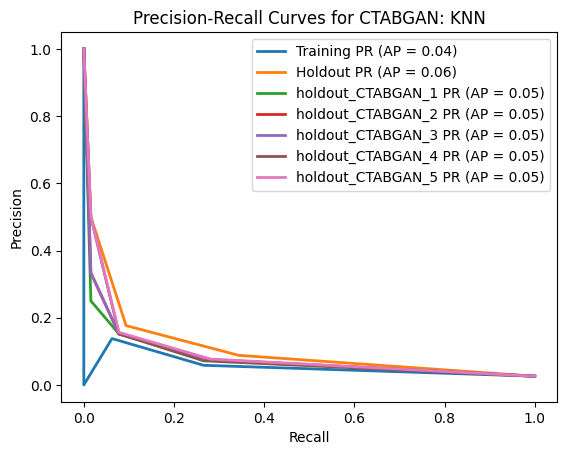

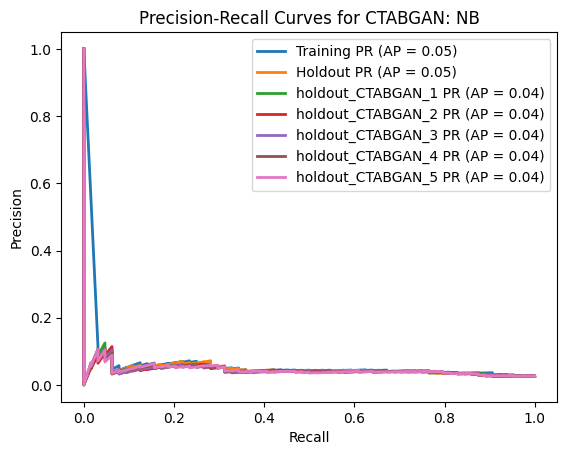

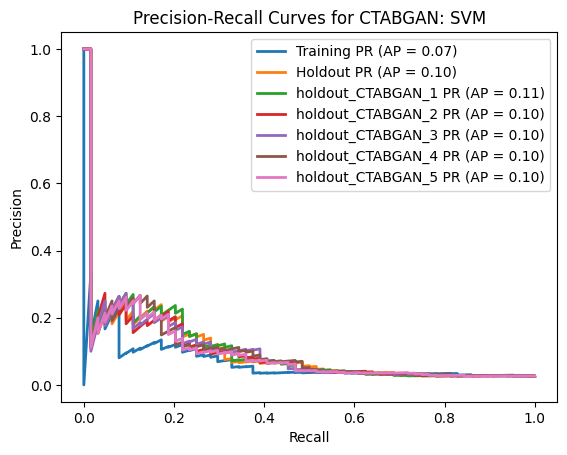

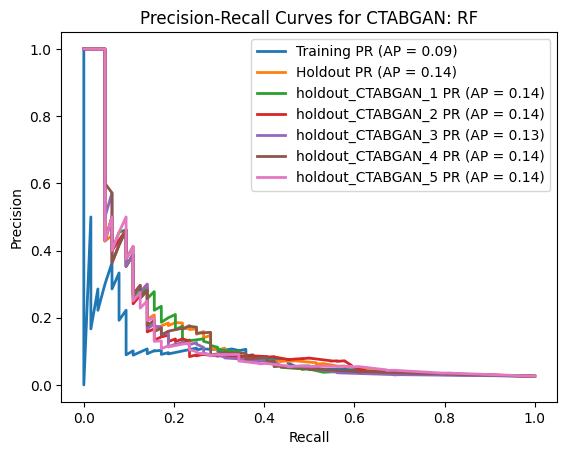

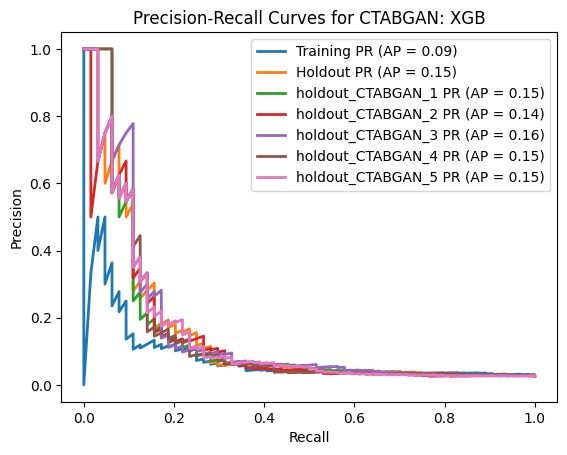

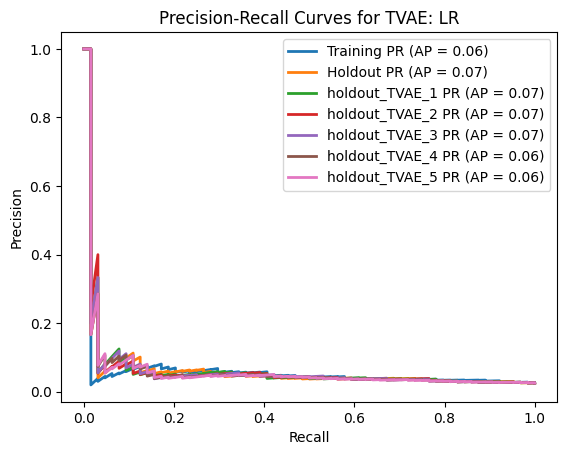

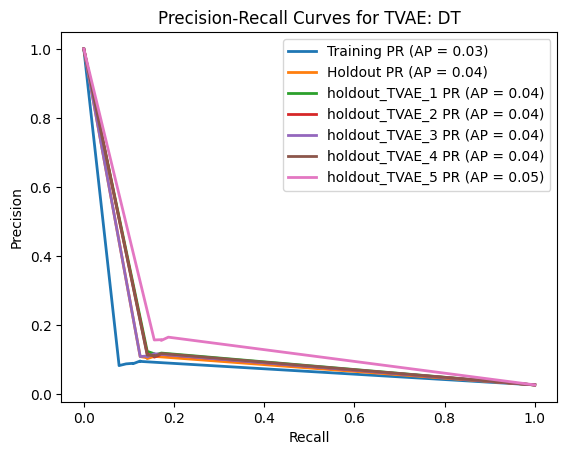

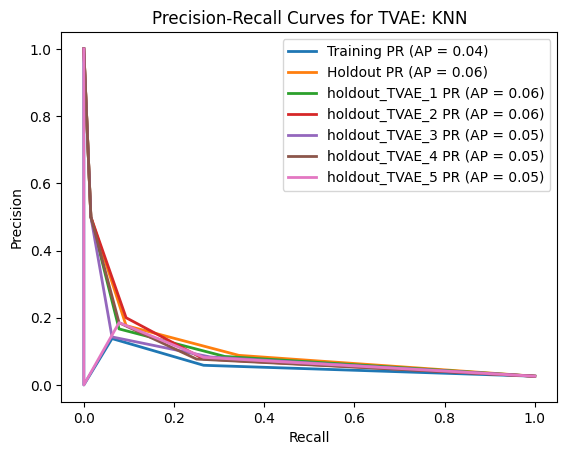

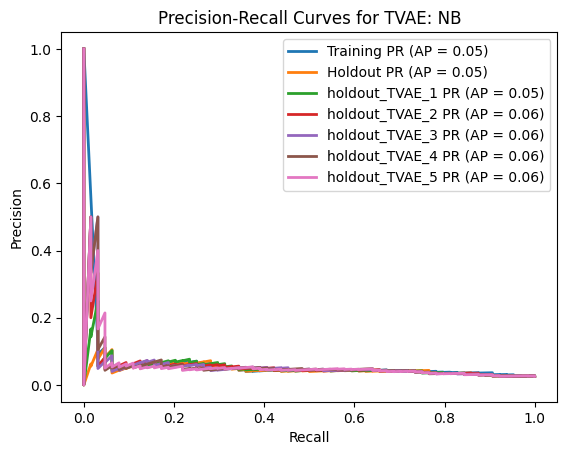

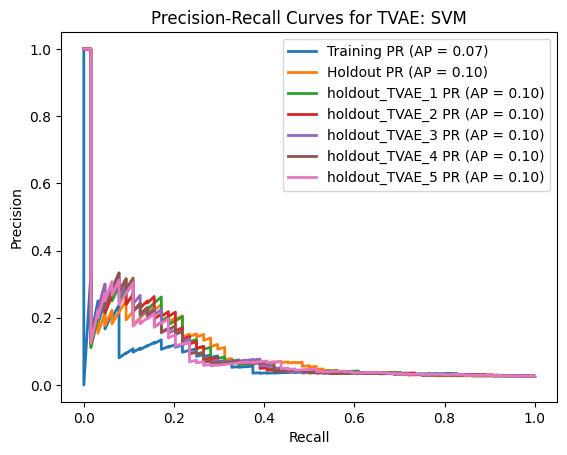

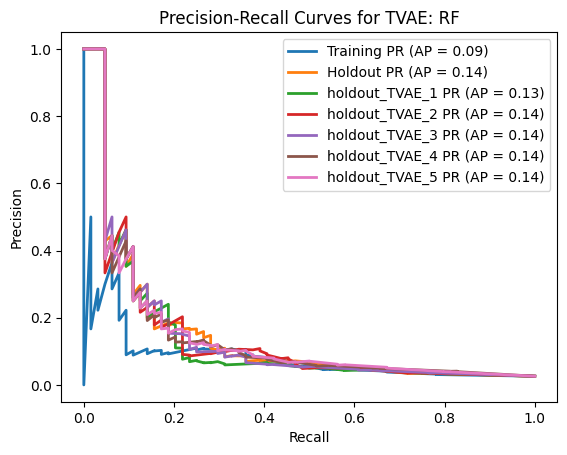

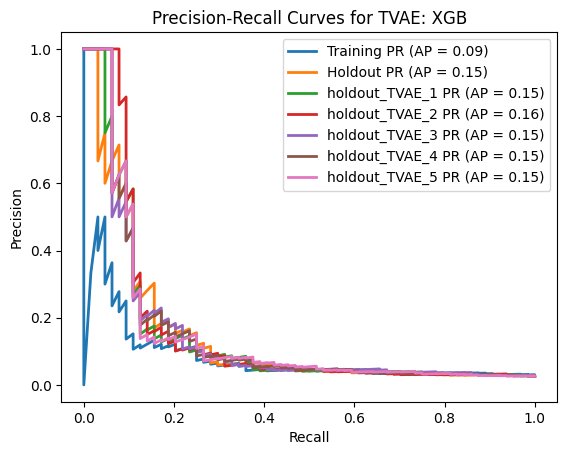

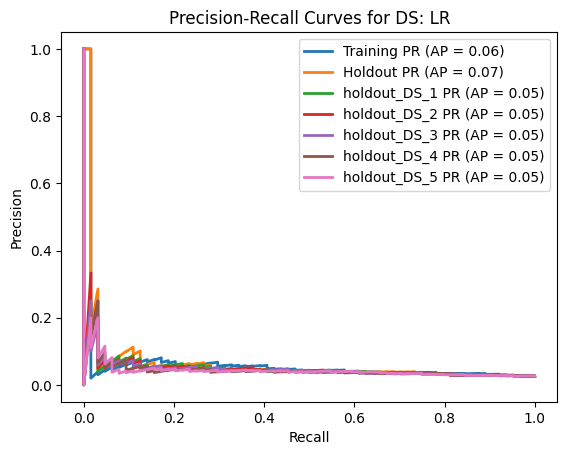

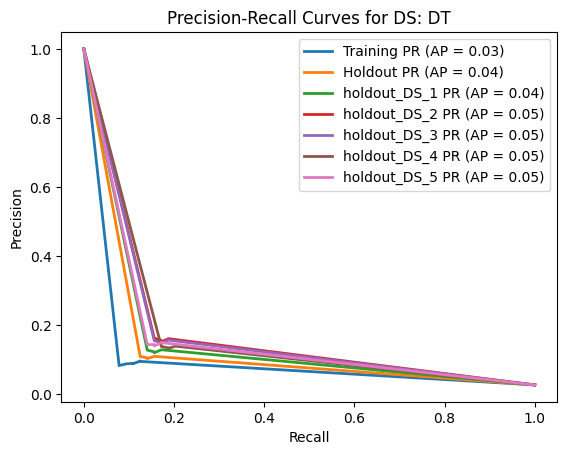

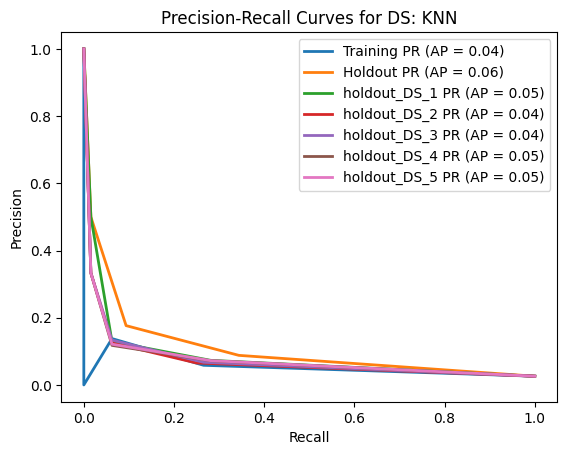

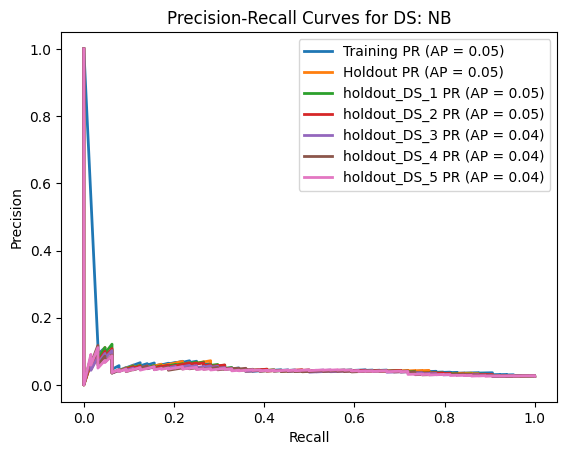

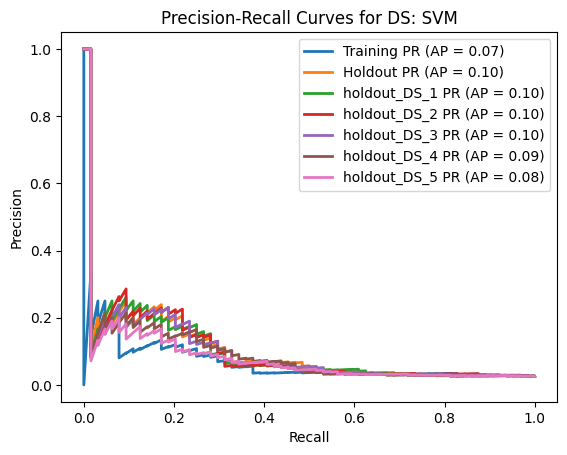

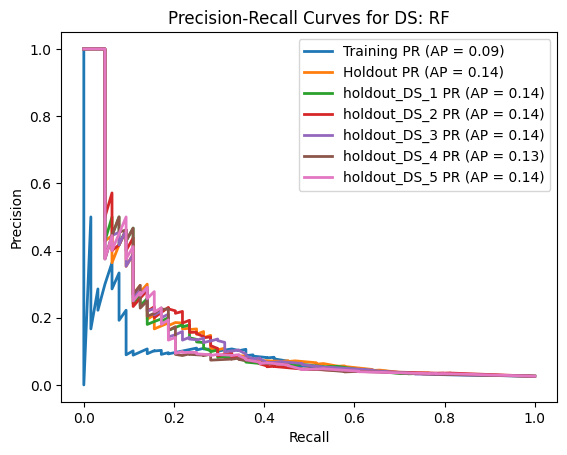

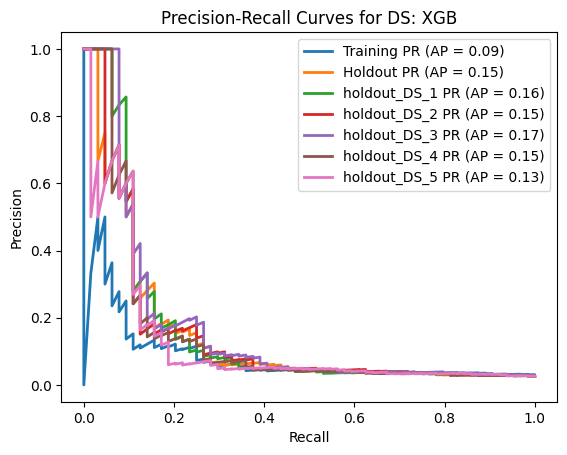

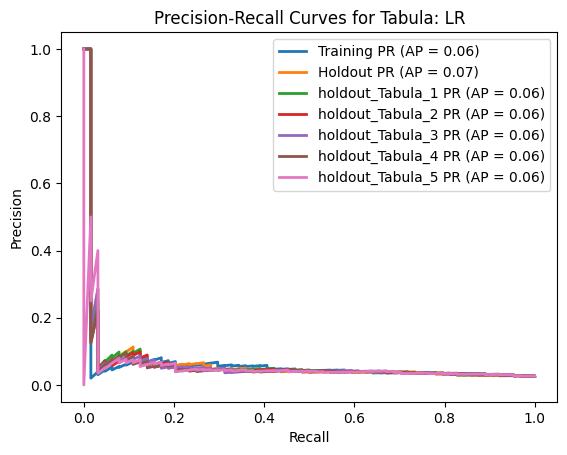

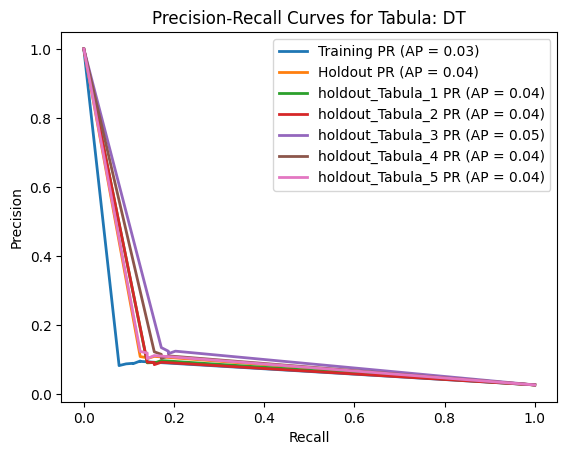

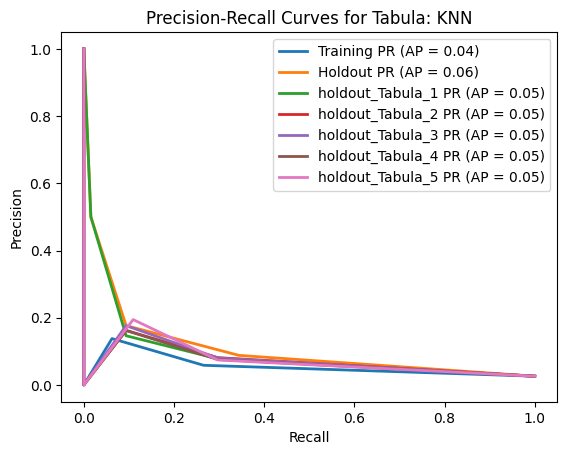

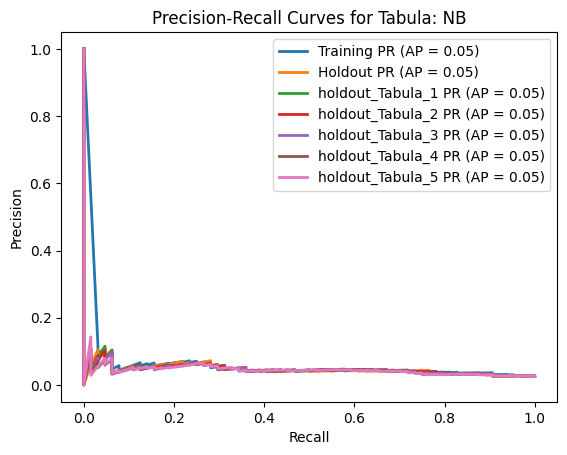

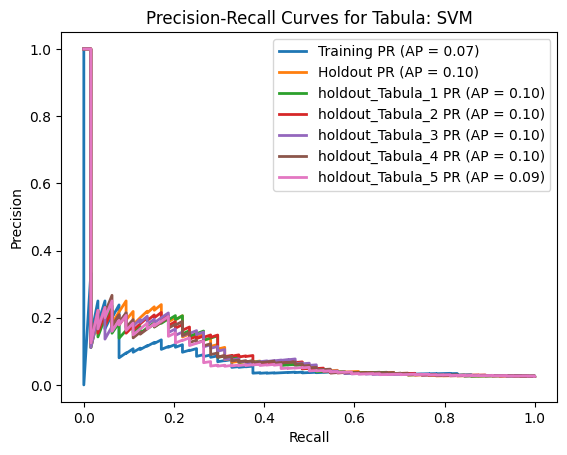

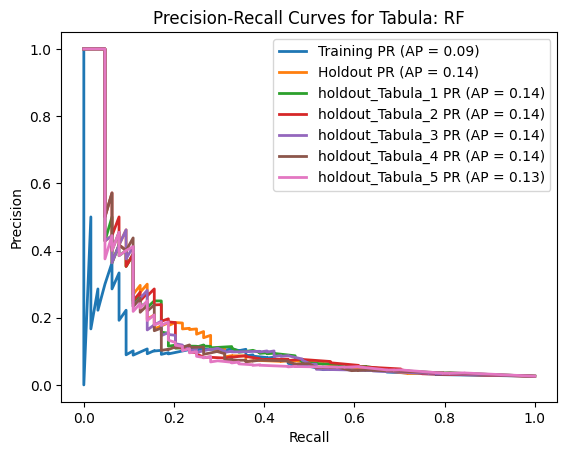

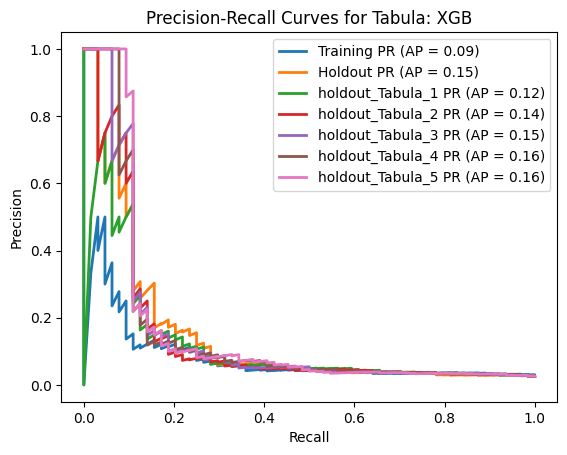

In [34]:
# Plot of Precision-Recall Curves

for syn in synthetic.keys():
    for model in models.keys():        
        for r in range(7):
            ratio = r -1
            if ratio == -1:
                index_name = 'Training'
            elif ratio == 0:
                index_name = 'Holdout'
            else:
                index_name = f'holdout_{syn}_{ratio}'
            ap = globals()[f'{index_name}_{model}_ap']
            plt.plot(globals()[f'{index_name}_{model}_recall'], globals()[f'{index_name}_{model}_precision'], lw=2, label=f'{index_name} PR (AP = {ap:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curves for {syn}: {model}')
        plt.legend(loc="upper right")
        plt.show()